In [ ]:
!pip install requests psycopg2-binary python-dotenv pandas "pymongo[srv]" minio wordcloud matplotlib pyarrow

In [1]:
import os
import requests
import psycopg2
from psycopg2 import sql
from datetime import datetime
import time
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
from minio import Minio
from minio.error import S3Error
import io
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure
import re
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# --- Configuration ---
# Load environment variables from a .env file
dotenv_path = Path('.') / '.env'
found_dotenv = load_dotenv(dotenv_path=dotenv_path)

if not found_dotenv:
    print(f"Warning: .env file not found at {dotenv_path.resolve()}.")
    print("Please ensure the .env file is in the same directory as your notebook.")


API_KEY = os.getenv("OWM_API_KEY") 
MONGO_URI = os.getenv("MONGO_URI")
DB_PASS = os.getenv("DB_PASS")
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY")

# --- Database Connection Details ---
DB_HOST = "postgres"
DB_PORT = "5432"
DB_NAME = "datawarehouse"
DB_USER = "dwadmin"


# --- Minio Connection Details ---
MINIO_ENDPOINT = "minio:9000"
MINIO_BUCKET_NAME = "raw-weather-data"
MINIO_MONGO_BUCKET_NAME = "mongo-backups"

# List of cities to process
CITIES = [
    ("São Paulo", "BR"),
    ("Rio de Janeiro", "BR"),
    ("New York", "US"),
    ("Tokyo", "JP"),
    ("London", "GB")
]


In [3]:
def get_minio_client():
    """Initializes and returns a Minio client."""
    print(f"Connecting to Minio at {MINIO_ENDPOINT}...")
    try:
        client = Minio(
            MINIO_ENDPOINT,
            access_key=MINIO_ACCESS_KEY,
            secret_key=MINIO_SECRET_KEY,
            secure=False
        )
        print("Minio client initialized.")
        return client
    except Exception as e:
        print(f"Error initializing Minio client: {e}")
        return None


In [4]:
def save_data_to_minio(minio_client, data):
    """Saves raw JSON data as a Parquet file in Minio."""
    if not data:
        return
    
    try:
        found = minio_client.bucket_exists(MINIO_BUCKET_NAME)
        if not found:
            minio_client.make_bucket(MINIO_BUCKET_NAME)
            print(f"Bucket '{MINIO_BUCKET_NAME}' created.")
        else:
            print(f"Bucket '{MINIO_BUCKET_NAME}' already exists.")

        df = pd.json_normalize(data)
        city_name = data.get('name', 'unknown_city').replace(' ', '_').lower()
        timestamp = datetime.utcnow().strftime('%Y%m%d_%H%M%S')
        object_name = f"{city_name}_{timestamp}.parquet"

        parquet_buffer = io.BytesIO()
        df.to_parquet(parquet_buffer, index=False)
        parquet_buffer.seek(0)

        minio_client.put_object(
            MINIO_BUCKET_NAME, object_name, data=parquet_buffer,
            length=len(parquet_buffer.getvalue()), content_type='application/octet-stream'
        )
        print(f"Successfully uploaded '{object_name}' to Minio.")

    except S3Error as s3_err:
        print(f"An S3 error occurred with Minio: {s3_err}")
    except Exception as e:
        print(f"An unexpected error occurred during Minio operation: {e}")


In [5]:
def get_weather_data(city, country_code):
    """Fetches weather data for a given city and country from the OpenWeatherMap API."""
    if not API_KEY:
        print("ERROR: OpenWeatherMap API key not found.")
        return None
    api_url = f"https://api.openweathermap.org/data/2.5/weather?q={city},{country_code}&appid={API_KEY}&units=metric&lang=pt_br"
    print(f"Fetching data for {city}, {country_code}...")
    try:
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        print("Data fetched successfully.")
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred fetching weather data: {e}")
    return None

In [6]:
def connect_to_db():
    """Establishes a connection to the PostgreSQL database."""
    print(f"Connecting to PostgreSQL database at {DB_HOST}...")
    try:
        conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
        print("Database connection successful.")
        return conn
    except psycopg2.OperationalError as e:
        print(f"Could not connect to the database: {e}")
    return None


In [7]:
def create_weather_table(conn):
    """Creates the 'weather_conditions' table if it does not already exist."""
    create_table_query = """
    CREATE TABLE IF NOT EXISTS weather_conditions (
        id SERIAL PRIMARY KEY, city VARCHAR(100) NOT NULL, country_code VARCHAR(10) NOT NULL,
        temperature_celsius NUMERIC(5, 2), feels_like_celsius NUMERIC(5, 2),
        humidity_percent INTEGER, weather_description VARCHAR(255),
        wind_speed_mps NUMERIC(5, 2), data_timestamp TIMESTAMP WITH TIME ZONE,
        recorded_at_utc TIMESTAMP WITH TIME ZONE DEFAULT (NOW() AT TIME ZONE 'UTC')
    );
    """
    try:
        with conn.cursor() as cursor:
            cursor.execute(create_table_query)
            conn.commit()
            print("Table 'weather_conditions' is ready.")
    except psycopg2.Error as e:
        print(f"Error creating table: {e}")
        conn.rollback()


In [8]:
def insert_weather_data(conn, weather_data):
    """Inserts the processed weather data into the database."""
    if not weather_data:
        return
    city, country = weather_data.get('name'), weather_data.get('sys', {}).get('country')
    temp, feels_like = weather_data.get('main', {}).get('temp'), weather_data.get('main', {}).get('feels_like')
    humidity, description = weather_data.get('main', {}).get('humidity'), weather_data.get('weather', [{}])[0].get('description')
    wind_speed, dt_object = weather_data.get('wind', {}).get('speed'), datetime.utcfromtimestamp(weather_data.get('dt', 0))
    insert_query = sql.SQL("""
    INSERT INTO weather_conditions (city, country_code, temperature_celsius, feels_like_celsius, humidity_percent, weather_description, wind_speed_mps, data_timestamp)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    """)
    record = (city, country, temp, feels_like, humidity, description, wind_speed, dt_object)
    try:
        with conn.cursor() as cursor:
            cursor.execute(insert_query, record)
            conn.commit()
            print(f"Successfully inserted data for {city}, {country} into PostgreSQL.")
    except psycopg2.Error as e:
        print(f"Error inserting data into PostgreSQL: {e}")
        conn.rollback()

In [9]:
def run_batch_weather_etl():
    """Main ETL workflow for processing a batch of cities."""
    db_connection = connect_to_db()
    minio_client = get_minio_client()
    if not db_connection or not minio_client:
        print("Aborting ETL process due to connection failure.")
        return
    try:
        create_weather_table(db_connection)
        for city, country_code in CITIES:
            print("-" * 40)
            data = get_weather_data(city, country_code)
            if data:
                save_data_to_minio(minio_client, data)
                insert_weather_data(db_connection, data)
            time.sleep(1)
    finally:
        if db_connection:
            db_connection.close()
            print("Database connection closed.")
        print("-" * 40)
        print("Batch process finished.")

In [10]:
def read_specific_parquet_file(minio_client, bucket_name, object_name):
    """Reads a specific Parquet file from Minio into a Pandas DataFrame."""
    print(f"Attempting to read '{object_name}' from bucket '{bucket_name}'...")
    try:
        response = minio_client.get_object(bucket_name, object_name)
        df = pd.read_parquet(io.BytesIO(response.read()))
        response.close()
        response.release_conn()
        print(f"Successfully read '{object_name}'.")
        return df
    except S3Error as s3_err:
        if s3_err.code == 'NoSuchKey':
            print(f"Error: The file '{object_name}' does not exist in the bucket '{bucket_name}'.")
        else:
            print(f"An S3 error occurred: {s3_err}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return None


In [11]:
def extract_mongo_to_minio(minio_client, mongo_uri, db_name, collection_name, bucket_name):
    """
    Extracts a MongoDB collection, converts it to Parquet, and uploads it to Minio.
    """
    print(f"Starting MongoDB extraction for db: '{db_name}', collection: '{collection_name}'...")
    try:
        print(f"Connecting to MongoDB")
        mongo_client = MongoClient(mongo_uri, serverSelectionTimeoutMS=5000)
        mongo_client.admin.command('ismaster')
        print("MongoDB connection successful.")
        
        db = mongo_client[db_name]
        collection = db[collection_name]
        
        documents = list(collection.find())
        if not documents:
            print(f"Warning: No documents found in collection '{collection_name}'. Nothing to upload.")
            return

        print(f"Found {len(documents)} documents. Converting to DataFrame...")
        df = pd.DataFrame(documents)
        
        if '_id' in df.columns:
            df['_id'] = df['_id'].astype(str)

        parquet_buffer = io.BytesIO()
        df.to_parquet(parquet_buffer, index=False)
        parquet_buffer.seek(0)
        
        found = minio_client.bucket_exists(bucket_name)
        if not found:
            minio_client.make_bucket(bucket_name)
            print(f"Bucket '{bucket_name}' created.")

        object_name = f"raw/mongodb/{collection_name}.parquet"
        minio_client.put_object(
            bucket_name, object_name, data=parquet_buffer,
            length=len(parquet_buffer.getvalue()), content_type='application/octet-stream'
        )
        print(f"Successfully uploaded '{object_name}' to Minio bucket '{bucket_name}'.")

    except ConnectionFailure as conn_err:
        print(f"MongoDB Connection Error: Could not connect to {mongo_uri}. Error: {conn_err}")
    except Exception as e:
        print(f"An unexpected error occurred during MongoDB extraction: {e}")
    finally:
        if 'mongo_client' in locals() and mongo_client:
            mongo_client.close()
            print("MongoDB connection closed.")


In [12]:
def generate_word_cloud_image(word_counts):
    """Generates and displays a word cloud image from word frequency data."""
    if not word_counts:
        print("Warning: No word counts to generate an image.")
        return
        
    freq_dict = {item['word']: item['count'] for item in word_counts}
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [13]:
def save_word_cloud_to_mongo(mongo_uri, db_name, collection_name, word_cloud_data):
    """Saves the word cloud JSON data to a new MongoDB collection."""
    print(f"Saving word cloud data to MongoDB collection: '{collection_name}'...")
    mongo_client = None
    try:
        mongo_client = MongoClient(mongo_uri, serverSelectionTimeoutMS=5000)
        mongo_client.admin.command('ismaster')
        
        db = mongo_client[db_name]
        collection = db[collection_name]
        
        # Clear the collection before inserting new data to ensure it's always up-to-date
        collection.delete_many({})
        
        # Insert the new word cloud data
        collection.insert_many(word_cloud_data)
        
        print(f"Successfully saved {len(word_cloud_data)} words to the '{collection_name}' collection.")

    except ConnectionFailure as conn_err:
        print(f"MongoDB Connection Error: {conn_err}")
    except Exception as e:
        print(f"An unexpected error occurred while saving to MongoDB: {e}")
    finally:
        if mongo_client:
            mongo_client.close()

In [14]:
def process_reviews_from_minio_to_word_cloud(minio_client, bucket_name, source_object_name):
    """
    Reads a Parquet file of reviews from Minio, generates a word cloud, and saves it.
    """
    print(f"Starting word cloud generation from file: '{source_object_name}'...")
    
    df = read_specific_parquet_file(minio_client, bucket_name, source_object_name)
    
    if df is None:
        print("Aborting word cloud generation as the source file could not be read.")
        return

    review_column = 'Review' 
    if review_column not in df.columns:
        print(f"Error: Column '{review_column}' not found in the DataFrame. Please check the column name.")
        return

    print(f"Processing text from '{review_column}' column...")
    all_text = ' '.join(df[review_column].astype(str).dropna())
    
    words = re.findall(r'\b\w+\b', all_text.lower())

    """
    Removing words that would not be usefull for an analysis.
    """
    stopwords = set([ 'the', 'a', 'to', 'is', 'in', 'it', 'and', 'of', 'for', 'i', 'was', 's','t','this','that','by','has','are','as'])
    filtered_words = [word for word in words if word not in stopwords and not word.isdigit()]
    
    word_counts = Counter(filtered_words)
    
    word_cloud_json_data = [{"word": word, "count": count} for word, count in word_counts.most_common(100)]
    
    if not word_cloud_json_data:
        print("Warning: No words left after processing. Cannot generate word cloud.")
        return
        
    print(f"Generated word counts for {len(word_cloud_json_data)} unique words.")

    try:
        # Save JSON to Minio
        json_data = json.dumps(word_cloud_json_data, indent=4).encode('utf-8')
        json_buffer = io.BytesIO(json_data)
        
        collection_name = source_object_name.split('/')[-1].replace('.parquet', '')
        output_object_name = f"processed/mongodb/{collection_name}_wordcloud.json"
        
        minio_client.put_object(
            bucket_name, output_object_name, data=json_buffer,
            length=len(json_data), content_type='application/json'
        )
        print(f"Successfully uploaded '{output_object_name}' to Minio.")

        # Save JSON to MongoDB
        save_word_cloud_to_mongo(
            mongo_uri=MONGO_URI,
            db_name='desafio_dataengenieer',
            collection_name='luizhuallpa_nuvem_palavras',
            word_cloud_data=word_cloud_json_data
        )

        # Generate and display the graphical word cloud
        generate_word_cloud_image(word_cloud_json_data)

    except Exception as e:
        print(f"An unexpected error occurred during file saving: {e}")


In [15]:
def run_mongo_to_word_cloud_pipeline(db_name, collection_name):
    """
    A single function to run the entire pipeline:
    1. Connect to Minio.
    2. Extract a MongoDB collection to a Parquet file in Minio.
    3. Process the Parquet file to generate and save word cloud outputs.
    """
    print(f"--- Starting full pipeline for MongoDB collection: '{collection_name}' ---")
    minio_client = get_minio_client()
    if not minio_client:
        print("Aborting pipeline due to Minio connection failure.")
        return

    # Step 1: Extract data from MongoDB to Minio
    extract_mongo_to_minio(
        minio_client,
        mongo_uri=MONGO_URI,
        db_name=db_name,
        collection_name=collection_name,
        bucket_name=MINIO_MONGO_BUCKET_NAME
    )
    
    print("-" * 40)

    # Step 2: Process the newly created Parquet file from Minio
    source_parquet_file = f"raw/mongodb/{collection_name}.parquet"
    process_reviews_from_minio_to_word_cloud(
        minio_client,
        bucket_name=MINIO_MONGO_BUCKET_NAME,
        source_object_name=source_parquet_file
    )
    print(f"--- Full pipeline for '{collection_name}' finished. ---")



In [16]:
run_batch_weather_etl()

Connecting to PostgreSQL database at postgres...
Database connection successful.
Connecting to Minio at minio:9000...
Minio client initialized.
Table 'weather_conditions' is ready.
----------------------------------------
Fetching data for São Paulo, BR...
Data fetched successfully.
Bucket 'raw-weather-data' already exists.
Successfully uploaded 'são_paulo_20250801_210252.parquet' to Minio.
Successfully inserted data for São Paulo, BR into PostgreSQL.
----------------------------------------
Fetching data for Rio de Janeiro, BR...
Data fetched successfully.
Bucket 'raw-weather-data' already exists.
Successfully uploaded 'rio_de_janeiro_20250801_210254.parquet' to Minio.
Successfully inserted data for Rio de Janeiro, BR into PostgreSQL.
----------------------------------------
Fetching data for New York, US...
Data fetched successfully.
Bucket 'raw-weather-data' already exists.
Successfully uploaded 'new_york_20250801_210256.parquet' to Minio.
Successfully inserted data for New York, US

--- Starting full pipeline for MongoDB collection: 'reviews' ---
Connecting to Minio at minio:9000...
Minio client initialized.
Starting MongoDB extraction for db: 'desafio_dataengenieer', collection: 'reviews'...
Connecting to MongoDB
MongoDB connection successful.
Found 8319 documents. Converting to DataFrame...
Successfully uploaded 'raw/mongodb/reviews.parquet' to Minio bucket 'mongo-backups'.
MongoDB connection closed.
----------------------------------------
Starting word cloud generation from file: 'raw/mongodb/reviews.parquet'...
Attempting to read 'raw/mongodb/reviews.parquet' from bucket 'mongo-backups'...
Successfully read 'raw/mongodb/reviews.parquet'.
Processing text from 'Review' column...
Generated word counts for 100 unique words.
Successfully uploaded 'processed/mongodb/reviews_wordcloud.json' to Minio.
Saving word cloud data to MongoDB collection: 'luizhuallpa_nuvem_palavras'...
Successfully saved 100 words to the 'luizhuallpa_nuvem_palavras' collection.


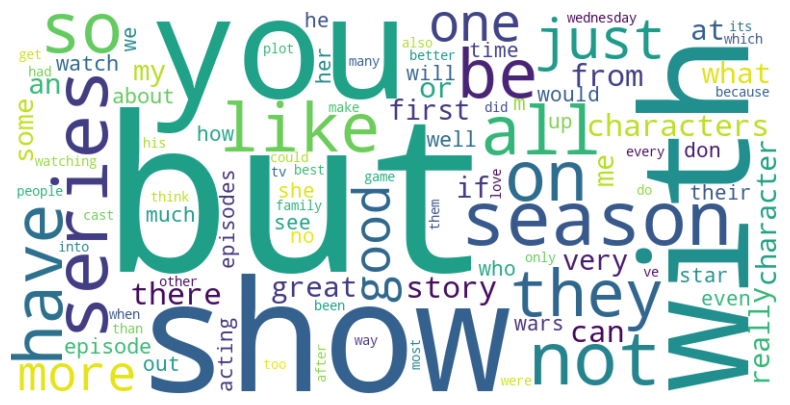

--- Full pipeline for 'reviews' finished. ---


In [17]:
run_mongo_to_word_cloud_pipeline(
    db_name='desafio_dataengenieer',
    collection_name='reviews'
)